In [1]:
# necessary imports
import numpy as np
from squlearn.util import Executor
from squlearn.feature_map import ChebPQC
from squlearn.kernel.matrix import FidelityKernel
from squlearn.kernel.matrix import ProjectedQuantumKernel
from squlearn.kernel.ml import QGPR, QSVR

In [2]:
# Generate training data.
def func(x):
    return np.sin(3 * x) * x * x


noise_std = 0.1
X_test = np.linspace(-1, 1, 100)
Y_test = func(X_test)
X_train = np.linspace(-1, 1, 15)
Y_train = func(X_train) + np.random.normal(scale=noise_std, size=len(X_train))

In [3]:
# set up quantum kernel and qgpr
num_qubits = 6
fmap = ChebPQC(num_qubits, num_features=1, num_layers=2)
q_kernel = FidelityKernel(
    feature_map=fmap, executor=Executor("statevector_simulator"), parameter_seed=0
)
qgpr_ansatz = QGPR(quantum_kernel=q_kernel, sigma=noise_std**2)
# qsvr = QSVR(quantum_kernel=q_kernel)

In [4]:
# perform qgpr
qgpr_ansatz.fit(X_train=X_train.reshape(-1, 1), y_train=Y_train)

QGPR(quantum_kernel=<squlearn.kernel.matrix.fidelity_kernel.FidelityKernel object at 0x00000249C92BAE90>,
     sigma=0.010000000000000002)

In [5]:
qgpr_mean, qgpr_std = qgpr_ansatz.predict(X_test=X_test.reshape(-1, 1))

Regularizing full Gram matrix
Reconstruction error 1.8842274718570626e-11


Text(0, 0.5, '$f(x)$')

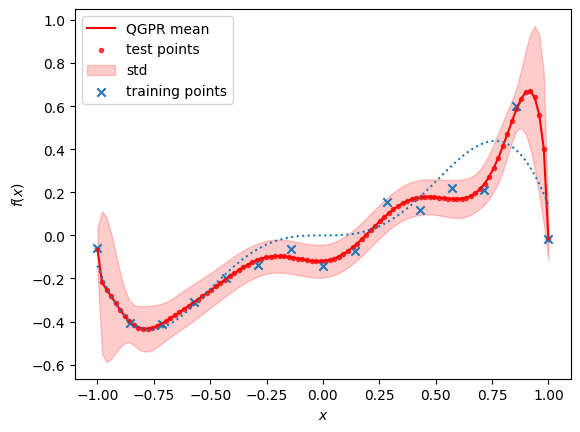

In [6]:
from matplotlib import pyplot as plt

# plot result
plt.plot(X_test.reshape(-1, 1), qgpr_mean, color="red", label="QGPR mean")
plt.scatter(
    X_test.reshape(-1, 1), qgpr_mean, marker=".", label="test points", color="red", alpha=0.7
)
plt.fill_between(
    X_test.reshape(-1),
    qgpr_mean.reshape(-1) - qgpr_std,
    qgpr_mean.reshape(-1) + qgpr_std,
    color="red",
    label="std",
    alpha=0.2,
)
plt.scatter(X_train, Y_train, marker="x", label="training points")
plt.plot(X_test, Y_test, linestyle="dotted")
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")

In [7]:
from sklearn.model_selection import cross_val_score
from squlearn.kernel.ml import QSVR

qsvr = QSVR(quantum_kernel=q_kernel)
cross_val_score(qsvr, X_train.reshape(-1, 1), Y_train, cv=5)

array([ -2.04757866,  -8.86629307,  -6.07780361, -38.83214689,
        -1.75792235])

In [8]:
# there is also the possibility of using custom sklearn methods with the kernel wrapper
from squlearn.kernel.matrix.kernel_util import kernel_wrapper
from sklearn.gaussian_process import GaussianProcessRegressor

wrapped_kernel = kernel_wrapper(q_kernel)
sk_gp = GaussianProcessRegressor(kernel=wrapped_kernel, alpha=0.1)
sk_gp.fit(X_train.reshape(-1, 1), Y_train)
sk_mean = sk_gp.predict(X_test.reshape(-1, 1))